## Tutorial covering the non-local routines and the lambda correction

In the main file (dga_main.py) this is a little bit more convoluted due to mpi support. Specifically, the Bethe-Salpeter
equation is diagonal in both the bosonic frequency $\omega$ and the corresponding momentum $q$. Consequently, mpi
parallelization over these indizes is a simple way to scale the calcuations on clusters like the Vienna Scientific Cluster (VSC).


In [1]:
# importing necessary modules

import sys,os
sys.path.append('../tests/')

# basic python modules always used
import numpy as np
import matplotlib.pyplot as plt

# dga modules needed for this tutorial
import dga.matsubara_frequencies as mf
import dga.brillouin_zone as bz
import dga.two_point as twop
import dga.bubble as bub
import dga.local_four_point as lfp
import dga.four_point as fp

# test data module
from test_util import test_data as td


-------------
mu-dmft: 2.4071092947399215
mu-k-mean: 2.4053435976337614
-------------


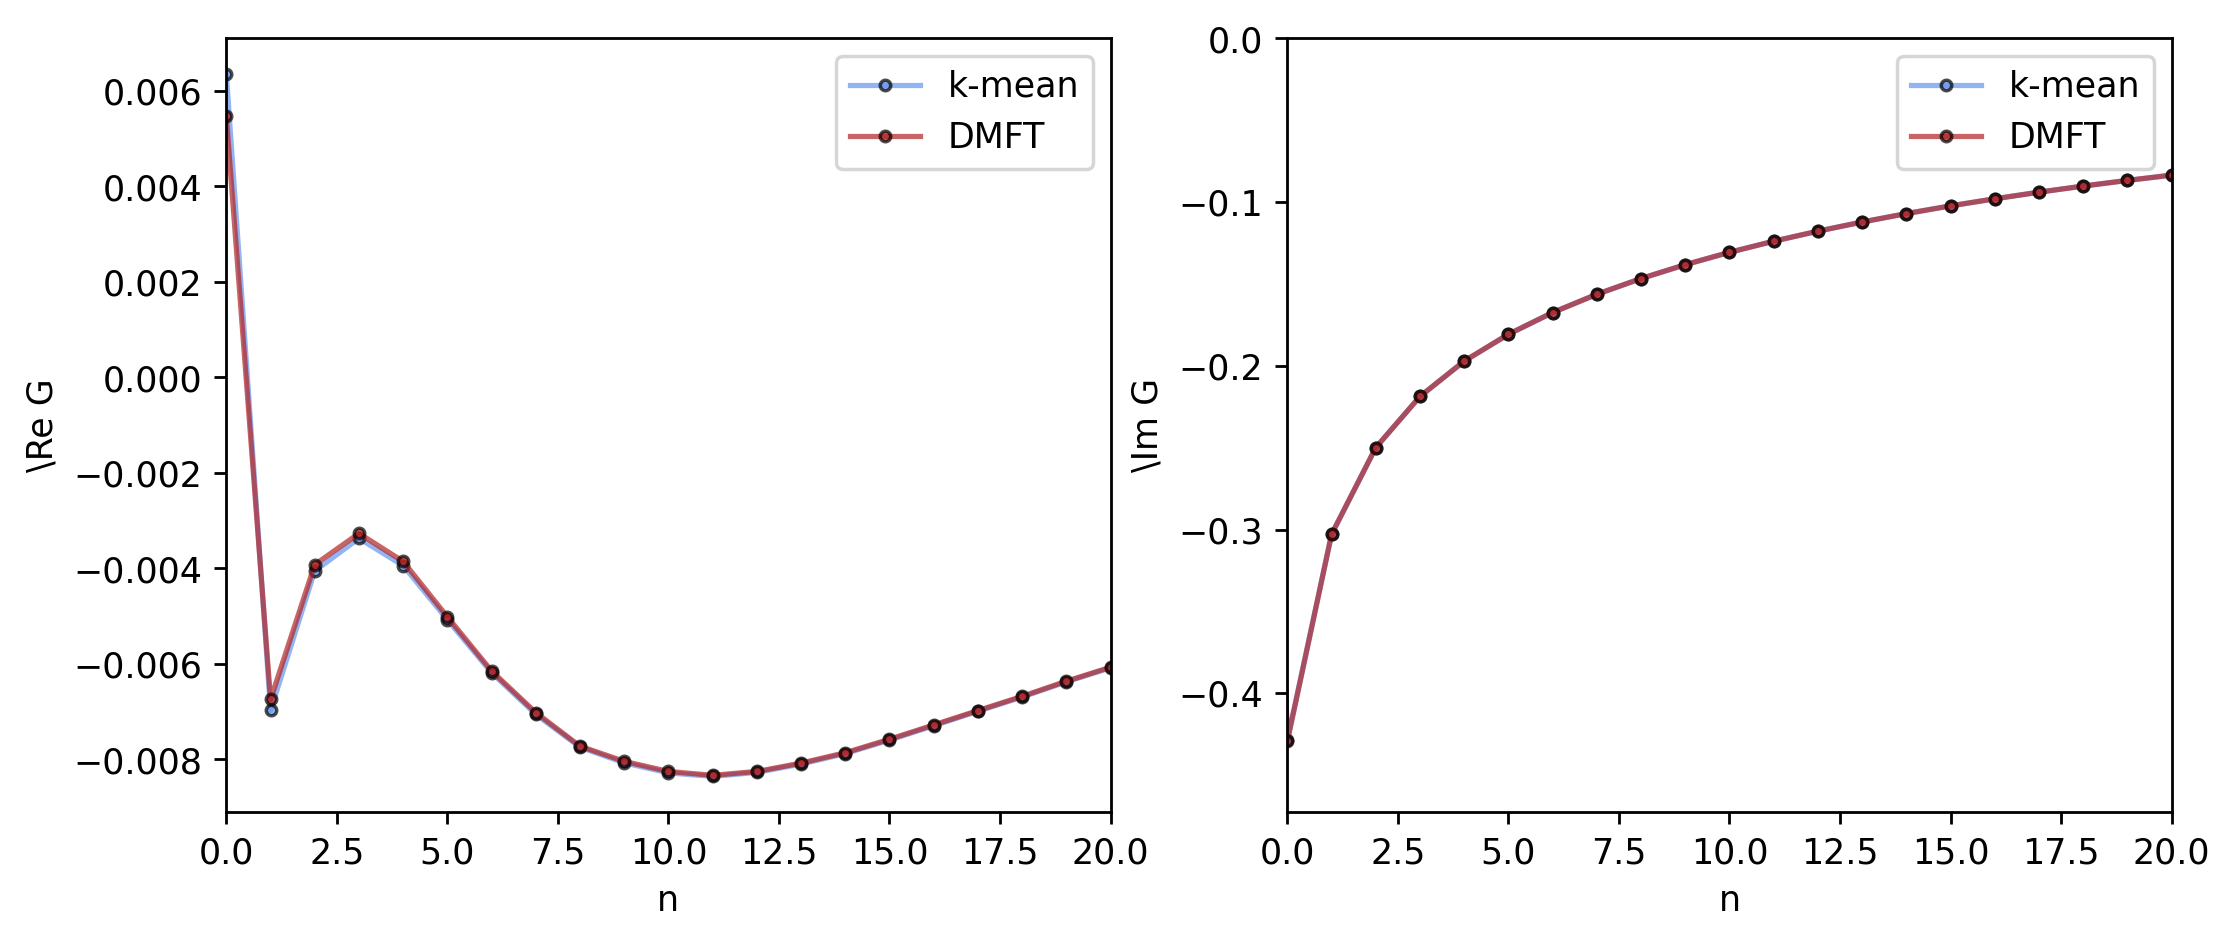

In [2]:
# Loading and preparing the dmft input data

dmft_data, hr = td.load_minimal_dataset()
nk = (12,12,1) # use small mesh for this tutorial
# nk = (100,100,1) # use small mesh for this tutorial
symmetries = bz.two_dimensional_square_symmetries()
k_grid = bz.KGrid(nk,symmetries)
ek = hr.get_ek(k_grid)

# define core region where we take the full four-point function

siw_dmft = dmft_data['siw']
giw_dmft = dmft_data['giw']
n = dmft_data['n']
u = dmft_data['u']
mu_dmft = dmft_data['mu_dmft']
beta = dmft_data['beta']

wn = mf.wn(dmft_data['g4iw_dens'])
g2_dens = lfp.LocalFourPoint(channel='dens',mat = dmft_data['g4iw_dens'], beta=beta, u=u, is_full_w=True)
g2_magn = lfp.LocalFourPoint(channel='magn',mat = dmft_data['g4iw_magn'], beta=beta, u=u, is_full_w=True)

siwk_obj = twop.SelfEnergy(siw_dmft[None,None,None,:],beta)
giwk_obj = twop.GreensFunction(siwk_obj,ek,n=n)

print('-------------')
print(f'mu-dmft: {mu_dmft}')
print(f'mu-k-mean: {giwk_obj.mu}')
print('-------------')

plt.figure(figsize=(10,4), dpi=251)
plt.subplot(1,2,1)
plt.plot(mf.vn(giwk_obj.g_loc),giwk_obj.g_loc.real,'-o',color='cornflowerblue',markeredgecolor='k',alpha=0.7,label='k-mean')
plt.plot(mf.vn(giw_dmft),giw_dmft.real,'-o',color='firebrick',markeredgecolor='k',alpha=0.7,label='DMFT')
plt.xlabel(r'n')
plt.ylabel(r'\Re G')
plt.xlim(0,20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(mf.vn(giwk_obj.g_loc),giwk_obj.g_loc.imag,'-o',color='cornflowerblue',markeredgecolor='k',alpha=0.7,label='k-mean')
plt.plot(mf.vn(giw_dmft),giw_dmft.imag,'-o',color='firebrick',markeredgecolor='k',alpha=0.7,label='DMFT')
plt.xlabel(r'n')
plt.ylabel(r'\Im G')
plt.xlim(0,20)
plt.ylim(None,0)
plt.legend()

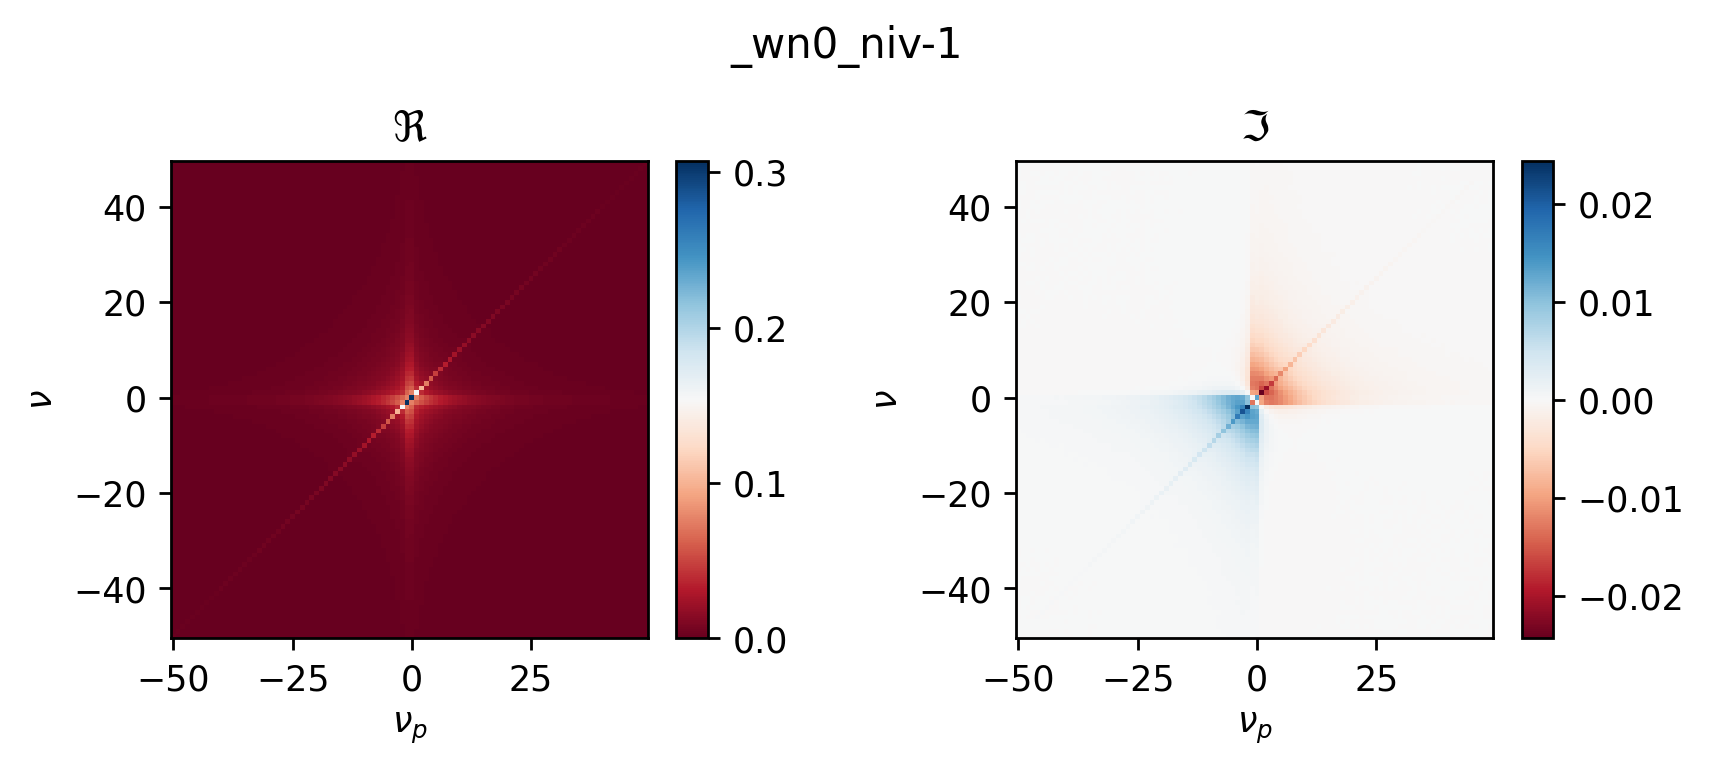

In [3]:

gchi_dens = lfp.gchir_from_g2(g2_dens, giwk_obj.g_loc)
gchi_magn = lfp.gchir_from_g2(g2_magn, giwk_obj.g_loc)

g2_magn.plot(verbose=True)

### Two-particle Irreducible vertex

The basis for the Bethe-Salpeter equation is the irreducibel vertex in the ph channel ($\Gamma$) and the bare bubble (two
Green's functions).

F = Gamma + Gamma Chi0 F
Chi0 = GG

This equation is (per se) exact, but in DGA we approximate F, by approximating \Gamma = \Gamma_{DMFT}

Since the non-local routines are computationally quite demanding, it is beneficial to define smaller omega ranges:

- core: range where Gamma = Gamma_DMFT
- urange: range where Gamma = U
- shell:  range where Gamma = 0 and chi = chi_0

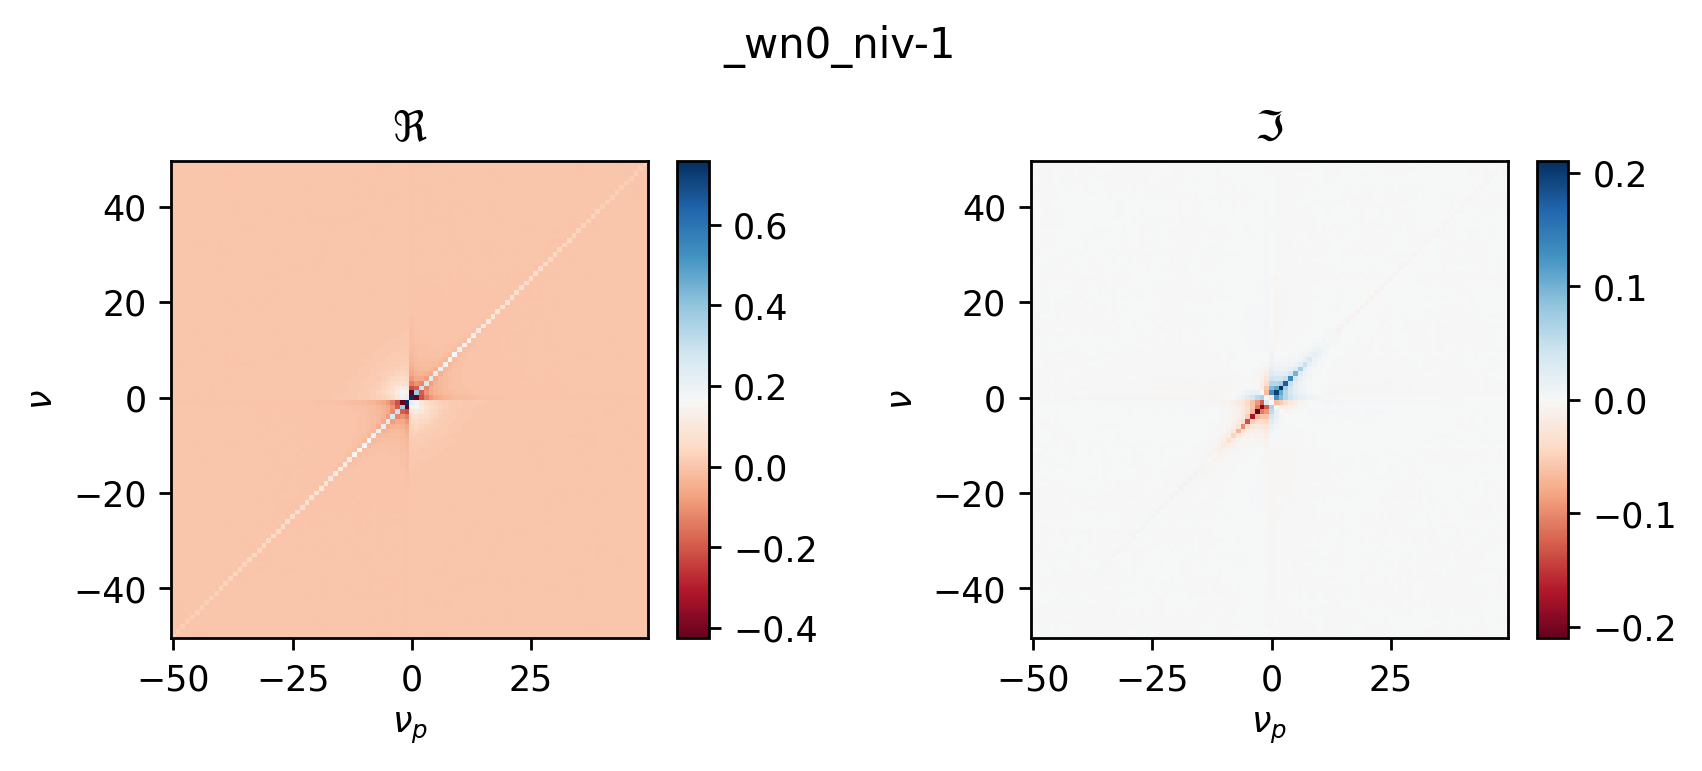

In [4]:
# Set frequency ranges:

niw_core = 50
niv_core = 50
niv_urange = 100 # number of frequencies for Gamma = 0.
niv_full = niv_core + niv_urange # frequncy ranges are additive

wn_core = mf.wn(niw_core)

# cut the frequency range for the generalized susceptibility:

# Set is_full_w to true. To tell the routines that the full bosonic frequency range was supplied.
gchi_dens.is_full_w = True
gchi_magn.is_full_w = True

gchi_dens.cut_iv(niv_core)
gchi_dens.cut_iw(niw_core)
gchi_magn.cut_iv(niv_core)
gchi_magn.cut_iw(niw_core)

gchi_dens.plot(verbose=True)

In [5]:
# define the bubble:
bubble_gen = bub.BubbleGenerator(wn_core,giwk_obj)

gchi0_urange = bubble_gen.get_gchi0(niv_full)

# Extract the irreducible vertex Gamma
gamma_dens = lfp.gamob2_from_gchir_urange(gchi_dens,gchi0_urange)
gamma_magn = lfp.gamob2_from_gchir_urange(gchi_magn,gchi0_urange)

In [6]:
# compute the asymptotic correction for the susceptibility. This is important for the lambda correction, such that all
# quantities are consistent.
vrg_dens, chi_dens_tilde = lfp.get_vrg_and_chir_tilde_from_gammar_uasympt(gamma_dens, bubble_gen,
                                                                        niv_shell=niv_urange)
vrg_magn, chi_magn_tilde = lfp.get_vrg_and_chir_tilde_from_gammar_uasympt(gamma_magn, bubble_gen,
                                                                        niv_shell=niv_urange)

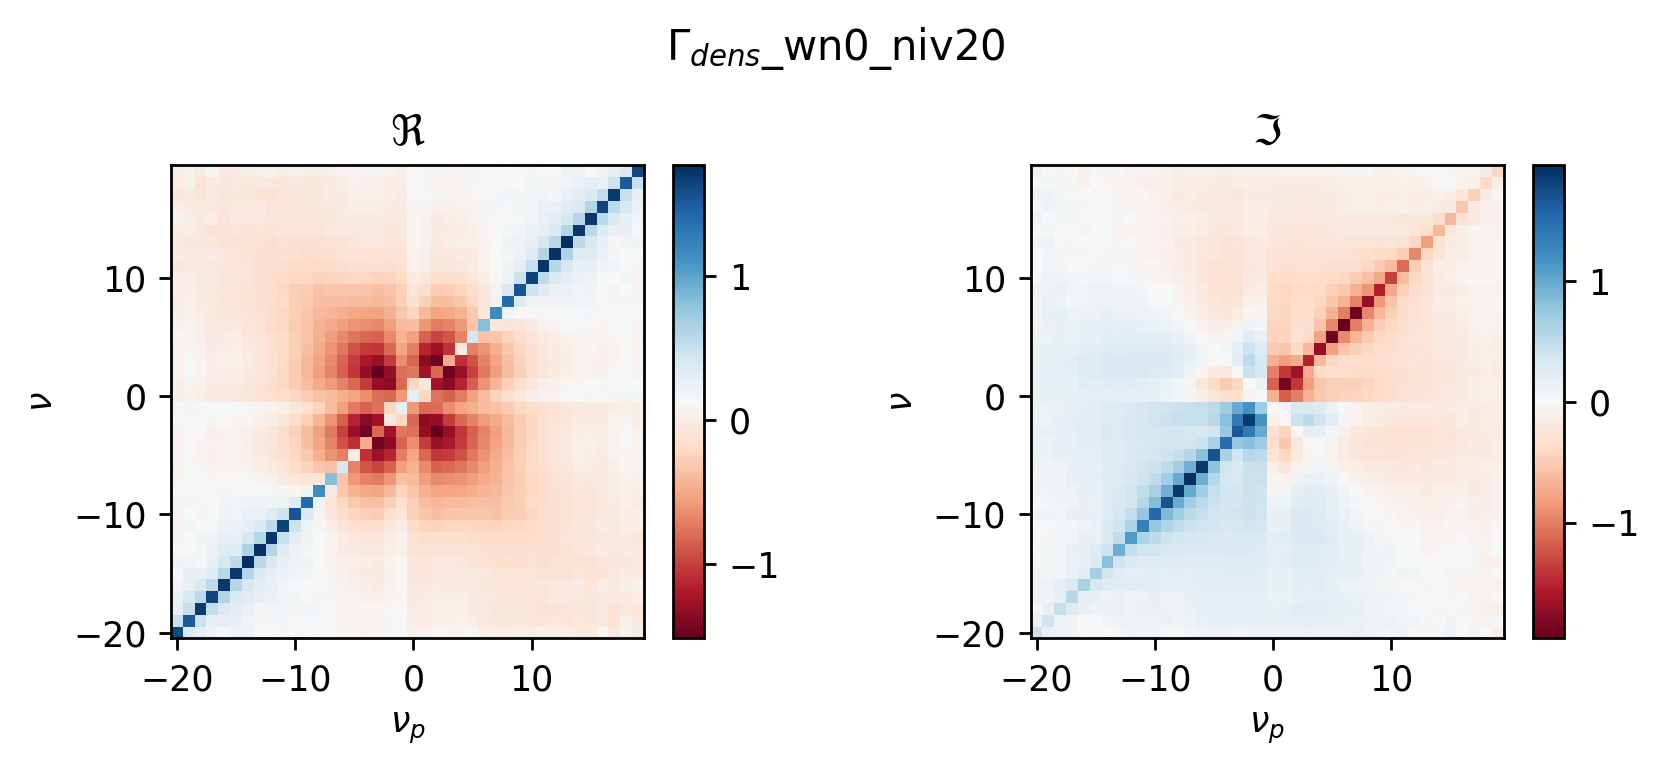

In [7]:
gamma_dens.plot(verbose=True,name='$\Gamma_{dens}$',niv=20,do_save=False)

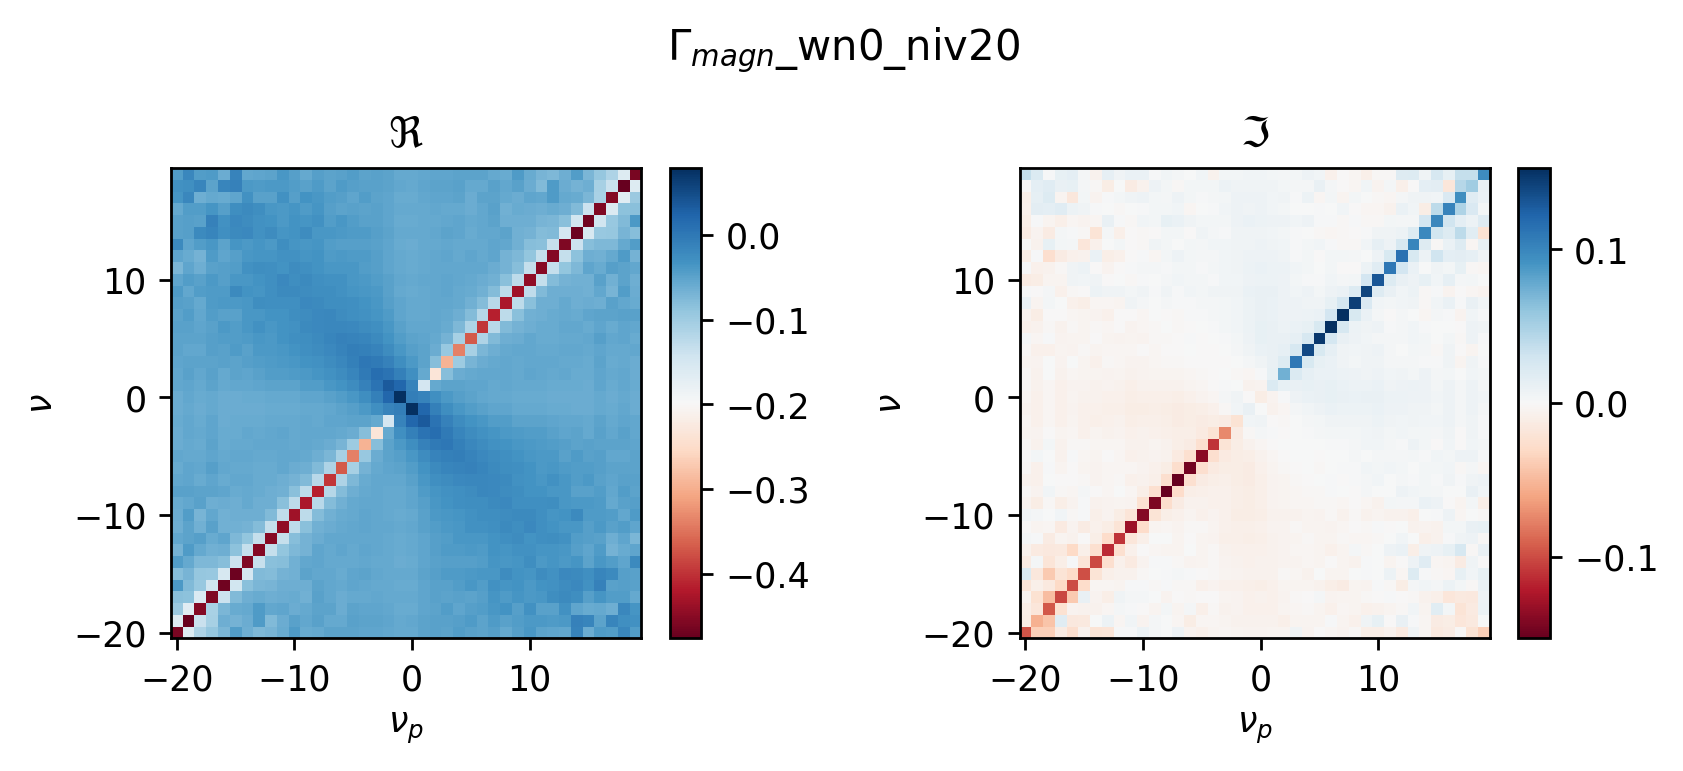

In [8]:
gamma_magn.plot(verbose=True,name='$\Gamma_{magn}$',niv=20, do_save=False)

In [9]:
# Build the different non-local Bubbles:
q_list = k_grid.get_q_list() # in the main code the parallelization is done over this list

gchi0_q_urange = bubble_gen.get_gchi0_q_list(niv_full, q_list)
chi0_q_urange = 1 / beta ** 2 * np.sum(gchi0_q_urange, axis=-1)
gchi0_q_core = mf.cut_v(gchi0_q_urange, niv_cut=niv_core, axes=-1)
chi0_q_core = 1 / beta ** 2 * np.sum(gchi0_q_core, axis=-1)
chi0q_shell = bubble_gen.get_asymptotic_correction_q(niv_full, q_list)

In [10]:
gchiq_aux = fp.get_gchir_aux_from_gammar_q(gamma_dens, gchi0_q_core)
chiq_aux = 1 / beta ** 2 * np.sum(gchiq_aux, axis=(-1, -2))

chi_lad_urange = fp.chi_phys_from_chi_aux_q(chiq_aux, chi0_q_urange, chi0_q_core, u, gamma_dens.channel)
chi_lad_dens = fp.chi_phys_asympt_q(chi_lad_urange, chi0_q_urange, chi0_q_urange + chi0q_shell)

In [11]:
chi_lad_dens = k_grid.map_fbz_list2mesh(chi_lad_dens)

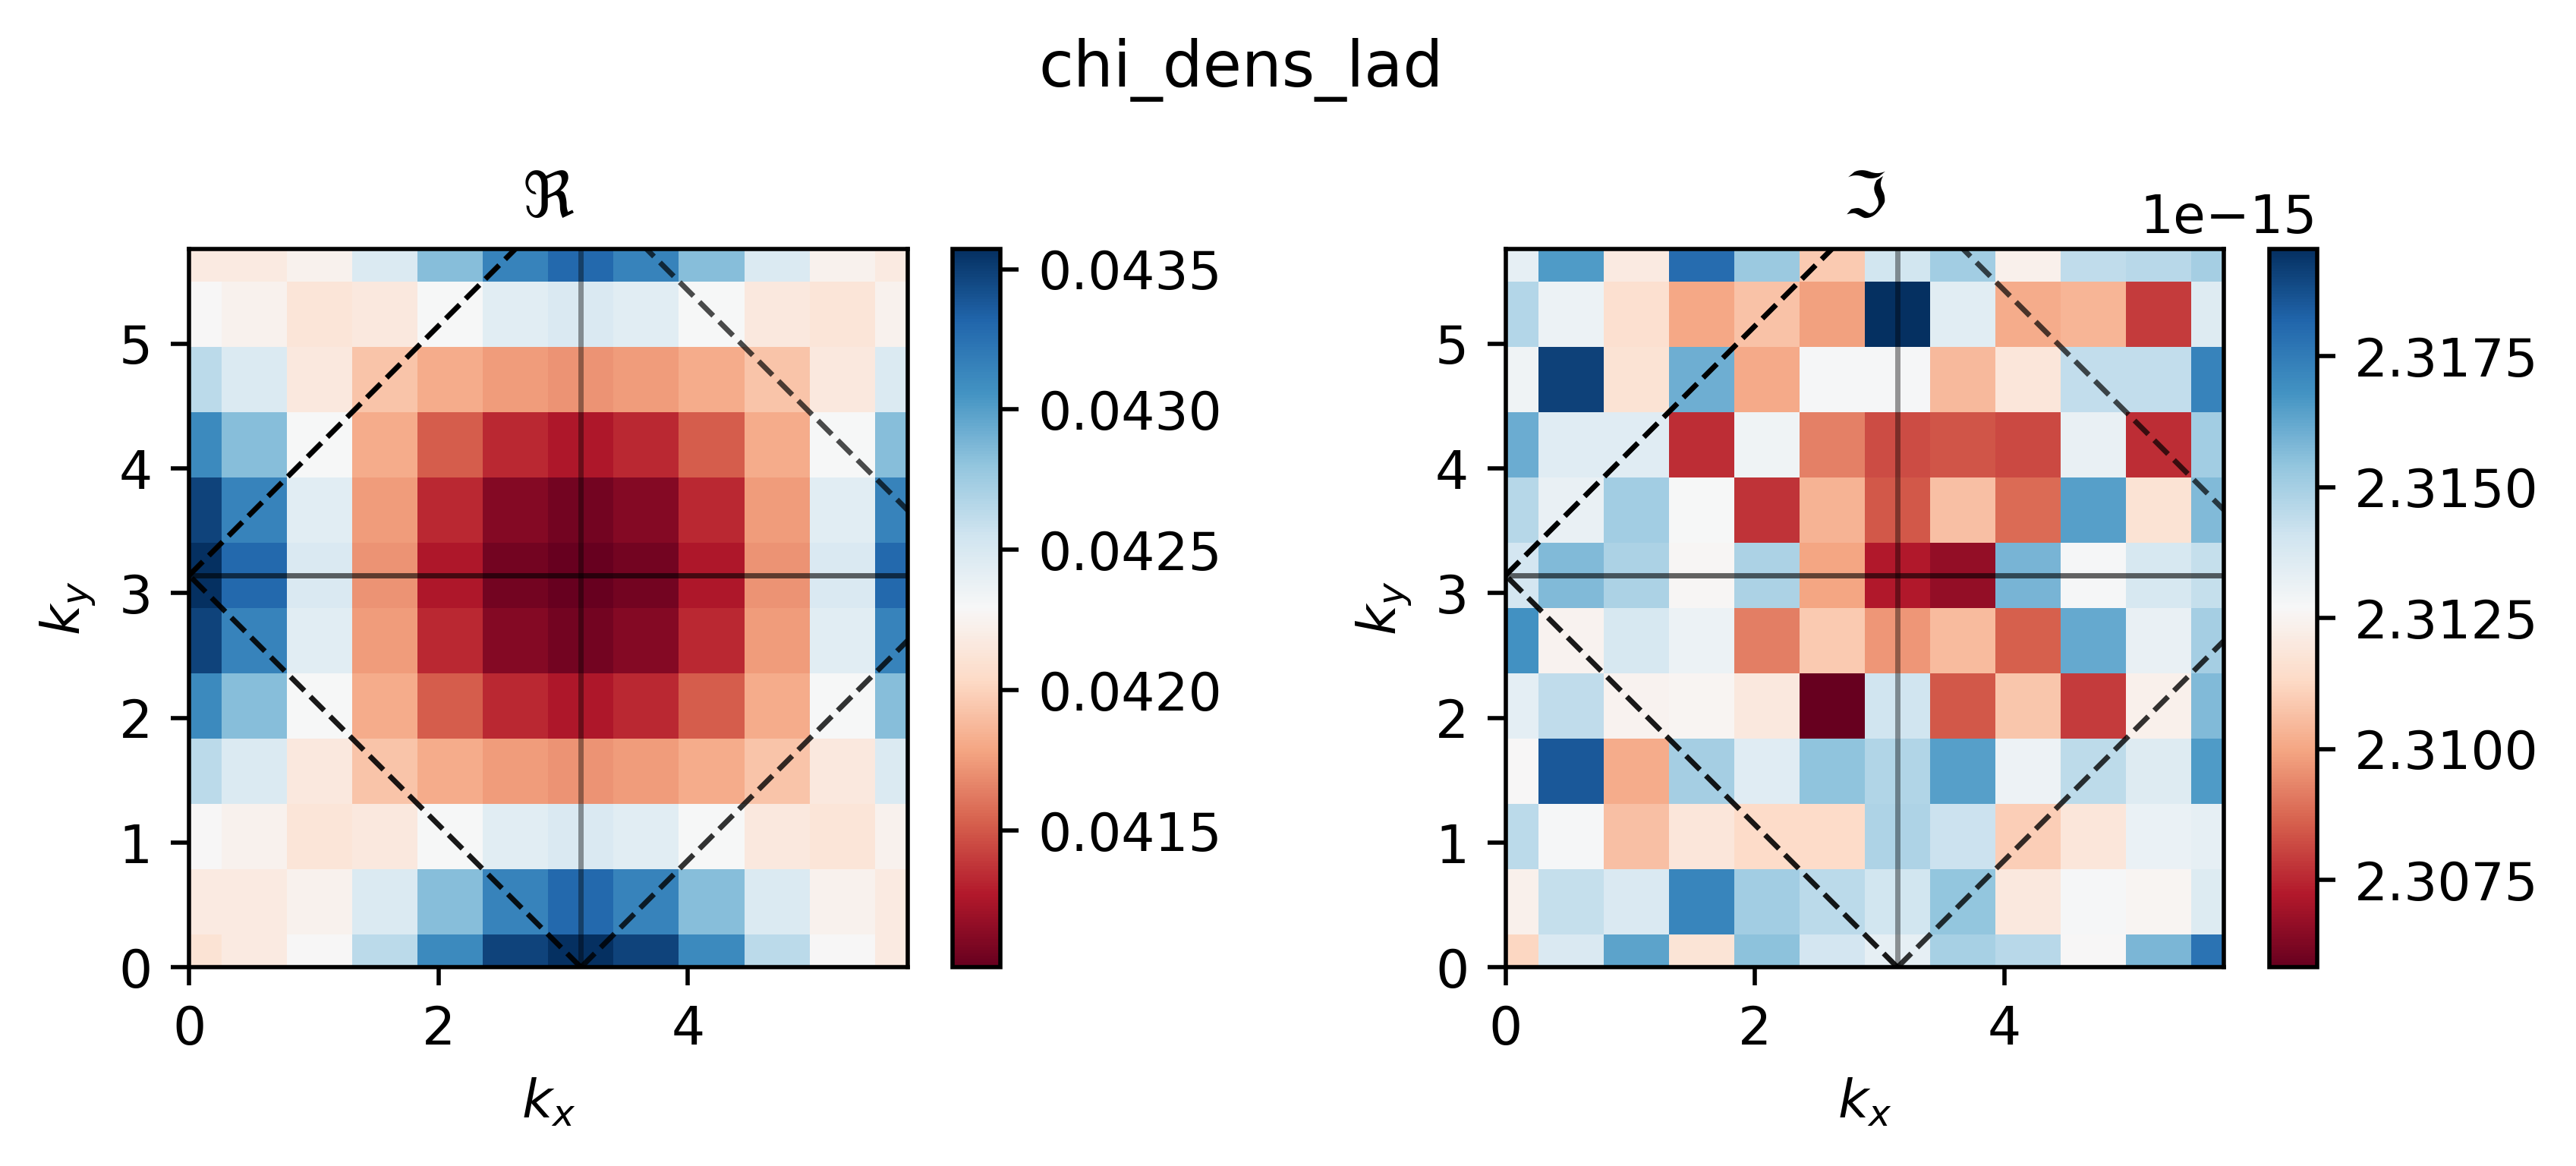

In [12]:
import dga.plotting as plotting

plotting.plot_kx_ky(chi_lad_dens[:,:,0,niw_core], k_grid.kx, k_grid.ky,name='chi_dens_lad',verbose=True,do_save=False)

In [13]:
gchiq_aux = fp.get_gchir_aux_from_gammar_q(gamma_magn, gchi0_q_core)
chiq_aux = 1 / beta ** 2 * np.sum(gchiq_aux, axis=(-1, -2))
chi_lad_urange = fp.chi_phys_from_chi_aux_q(chiq_aux, chi0_q_urange, chi0_q_core, u, gamma_magn.channel)
chi_lad_magn = fp.chi_phys_asympt_q(chi_lad_urange, chi0_q_urange, chi0_q_urange + chi0q_shell)

In [14]:
chi_lad_magn = k_grid.map_fbz_list2mesh(chi_lad_magn)

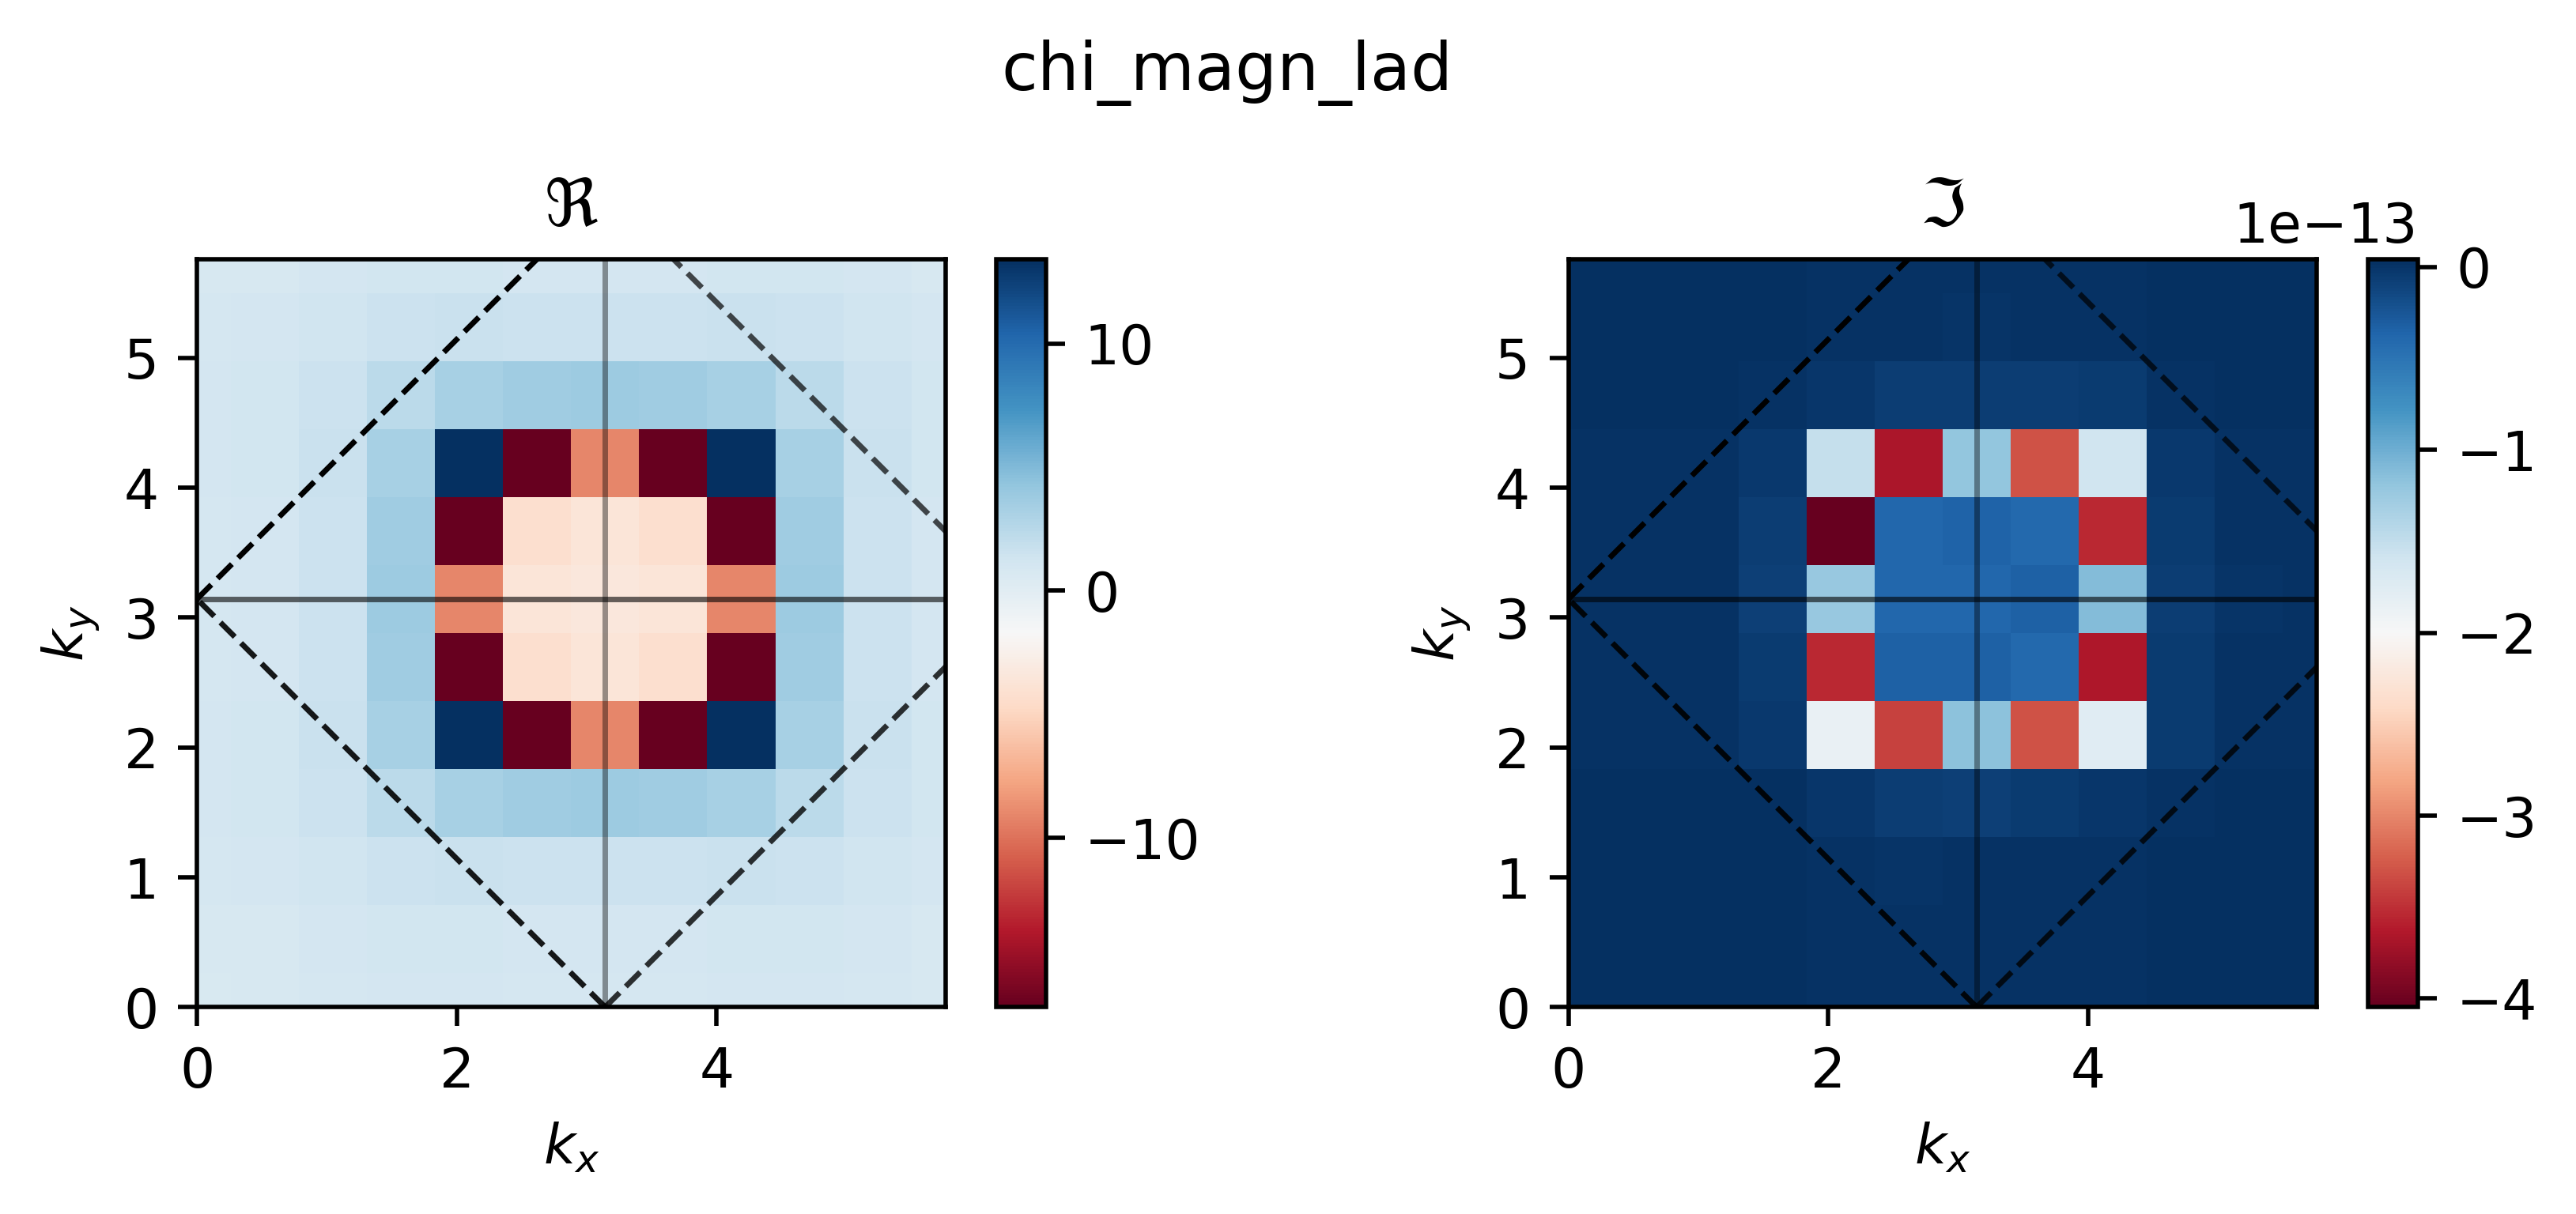

In [15]:
plotting.plot_kx_ky(chi_lad_magn[:,:,0,niw_core], k_grid.kx, k_grid.ky,name='chi_magn_lad',verbose=True,do_save=False)

### DMFT mean-field divergencies

In the previous plot one can observe negative values of the susceptibility. This signals that the system is unstable against
external perturbations and would like to enter an ordered phase. In the case of the Hubbard model, this is the antiferromagnetic
phase. However, in our DMFT run we explicitly suppressed this phase by enforcing spin-symmetry.

One should also note that this phase transition is not physical, but rather a mean-field artifact.

To remove this artifact we introduce the so-called lambda correction.

chi_lam = 1/(1/chi + lam)

Where lambda is chosen such that sum-rules are satisfied (see my thesis for details).


In [16]:
import dga.lambda_correction as lc

# we are ignoring asymptotic corrections for a moment
chi_magn = gchi_magn.contract_legs()
chi_dens = gchi_dens.contract_legs()
chi_lam_dens, chi_lam_magn, lambda_dens, lambda_magn = lc.lambda_correction(chi_lad_dens, chi_lad_magn, beta,
                                                                                chi_dens_tilde, chi_magn_tilde,
                                                                                lambda_corr='spch')

In [17]:
print('---------------')
print('lambda_dens: ', lambda_dens)
print('lambda_magn: ', lambda_magn)
print('---------------')

---------------
lambda_dens:  -1.4502679330801176
lambda_magn:  0.35548317353646147
---------------


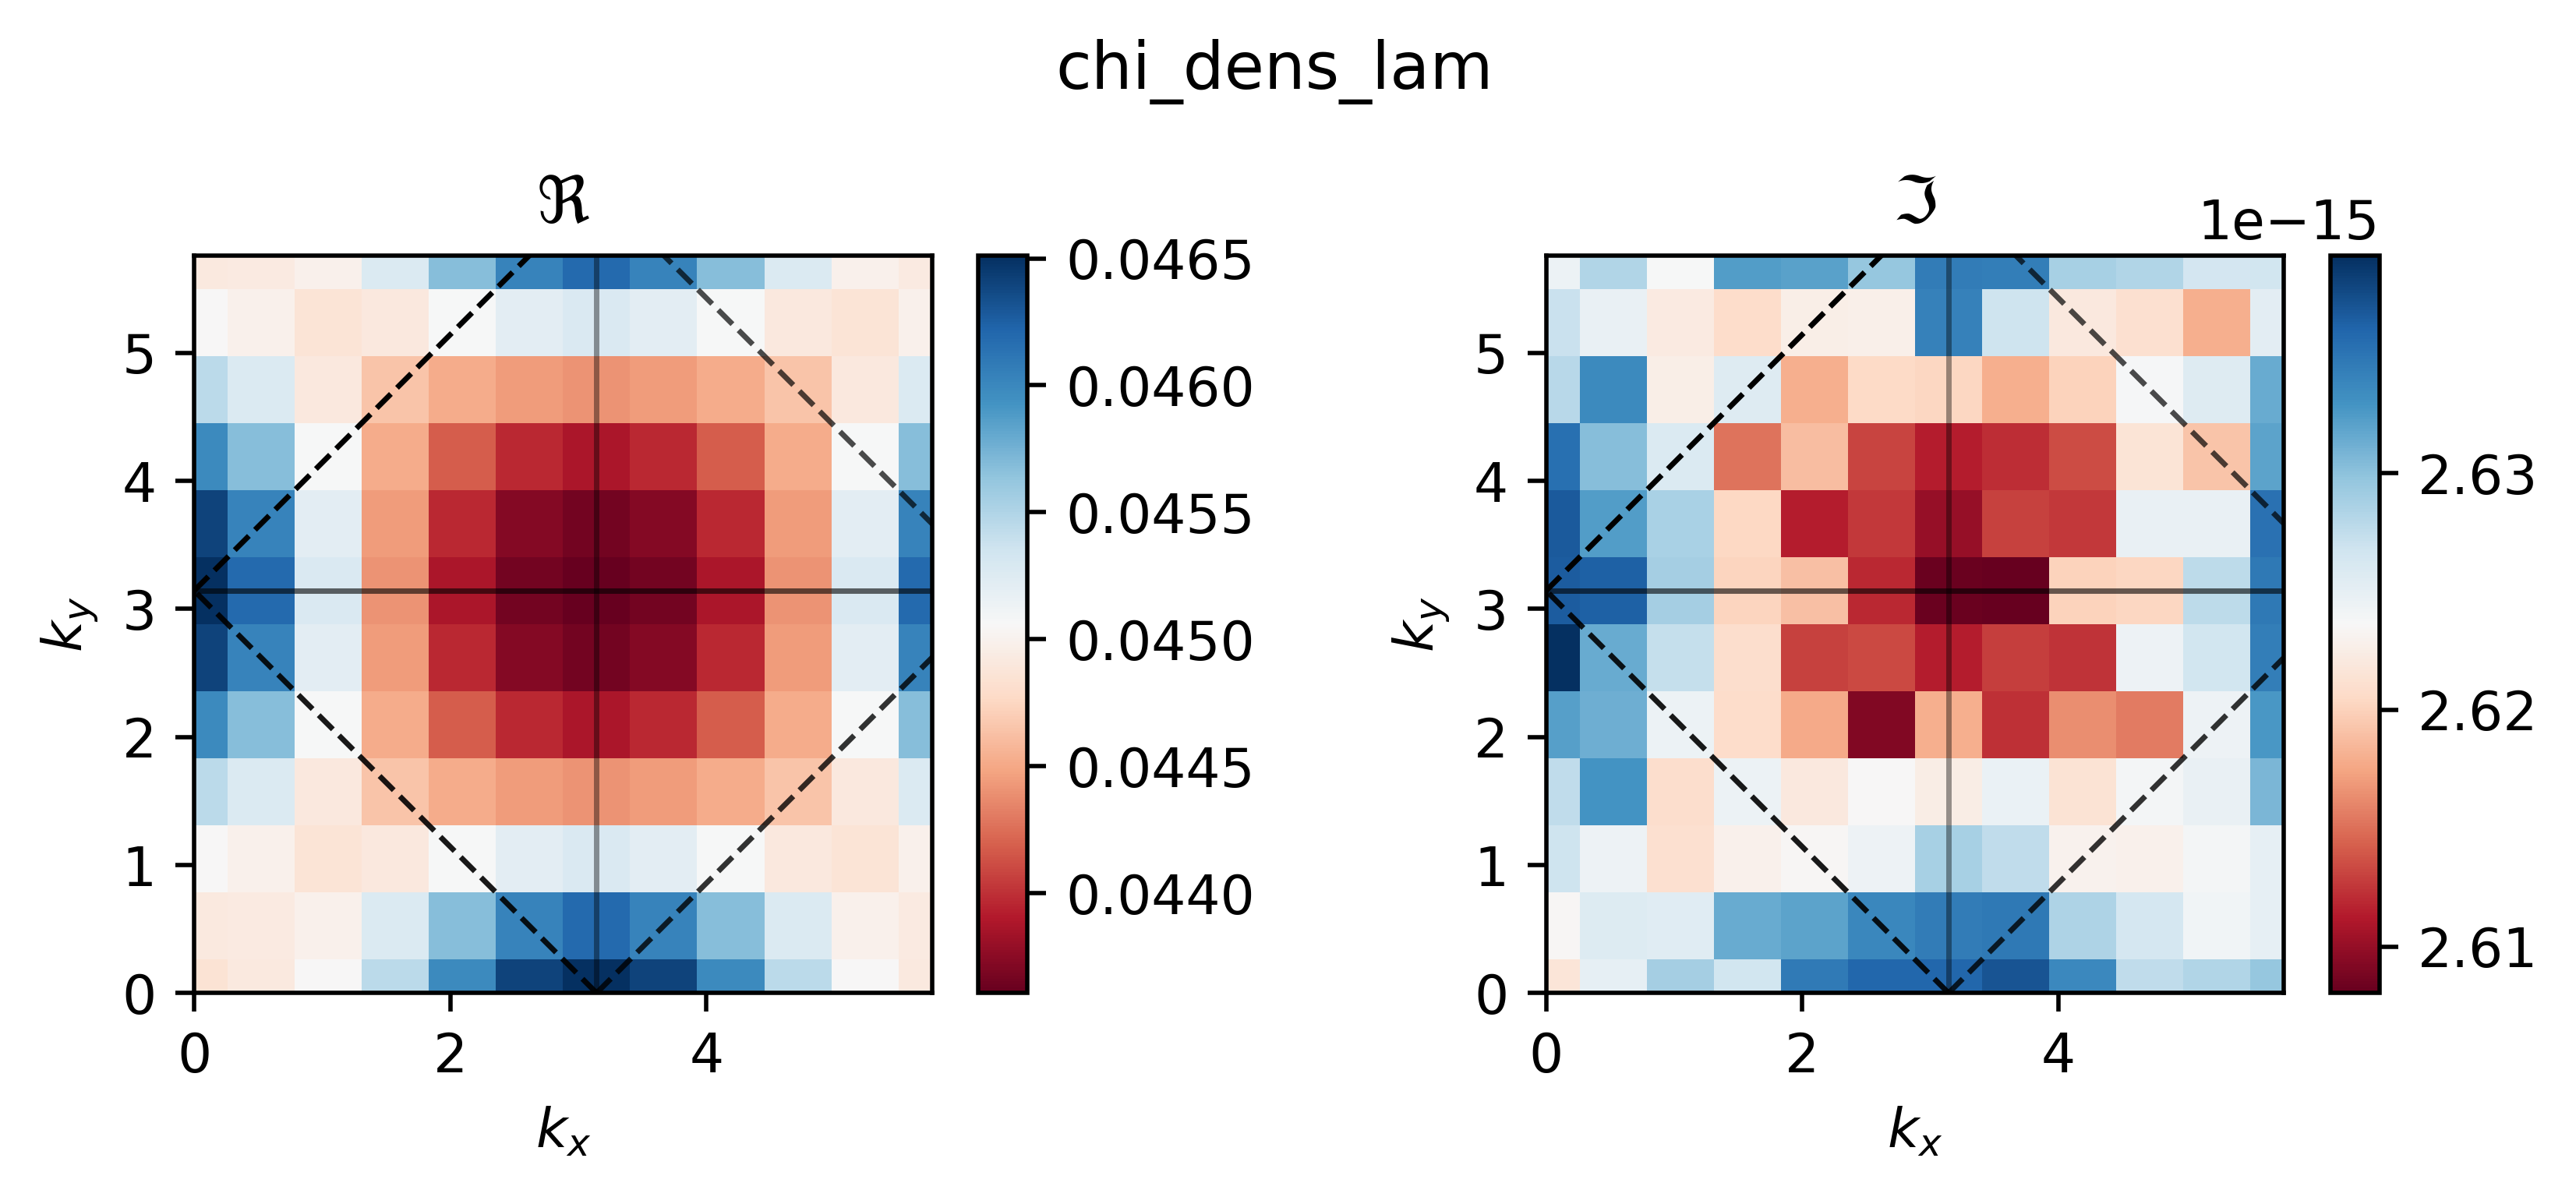

In [18]:
plotting.plot_kx_ky(chi_lam_dens[:,:,0,niw_core], k_grid.kx, k_grid.ky,name='chi_dens_lam',verbose=True,do_save=False)

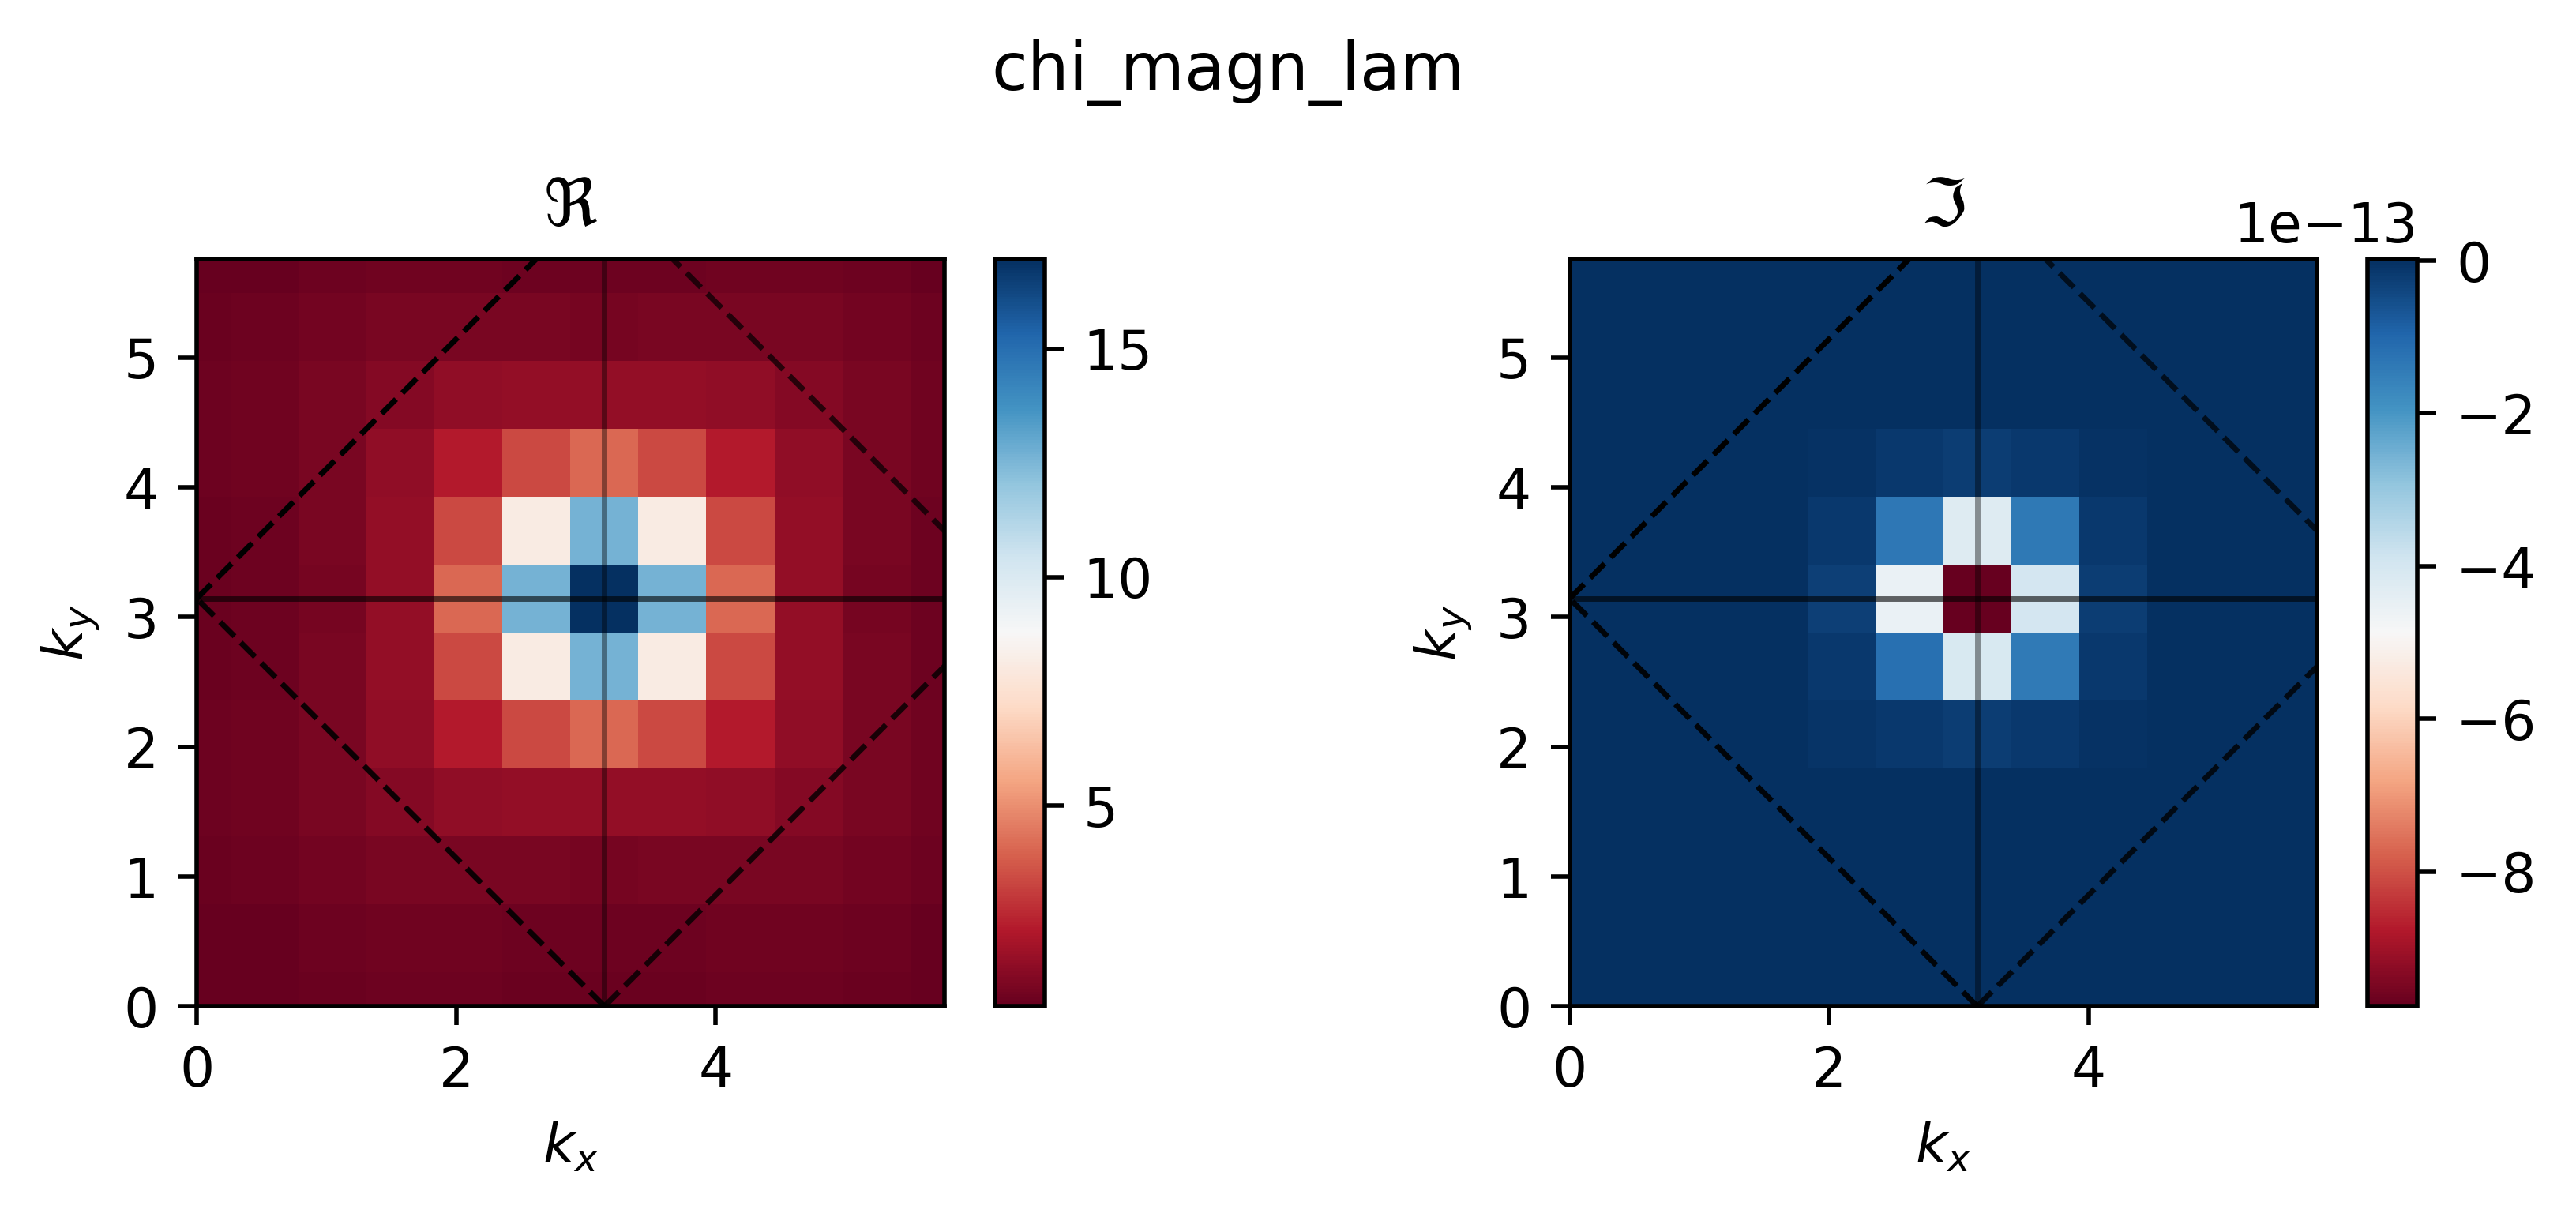

In [19]:
plotting.plot_kx_ky(chi_lam_magn[:,:,0,niw_core], k_grid.kx, k_grid.ky,name='chi_magn_lam',verbose=True,do_save=False)

In [20]:
import dga.lambda_correction as lc

# we are ignoring asymptotic corrections for a moment
chi_magn = gchi_magn.contract_legs()
chi_dens = gchi_dens.contract_legs()
chi_lam_dens, chi_lam_magn, lambda_dens, lambda_magn = lc.lambda_correction(chi_lad_dens, chi_lad_magn, beta,
                                                                                chi_dens_tilde, chi_magn_tilde,
                                                                                lambda_corr='sp')

In [21]:
print('---------------')
print('lambda_dens: ', lambda_dens)
print('lambda_magn: ', lambda_magn)
print('---------------')

---------------
lambda_dens:  0
lambda_magn:  0.35268916263152733
---------------


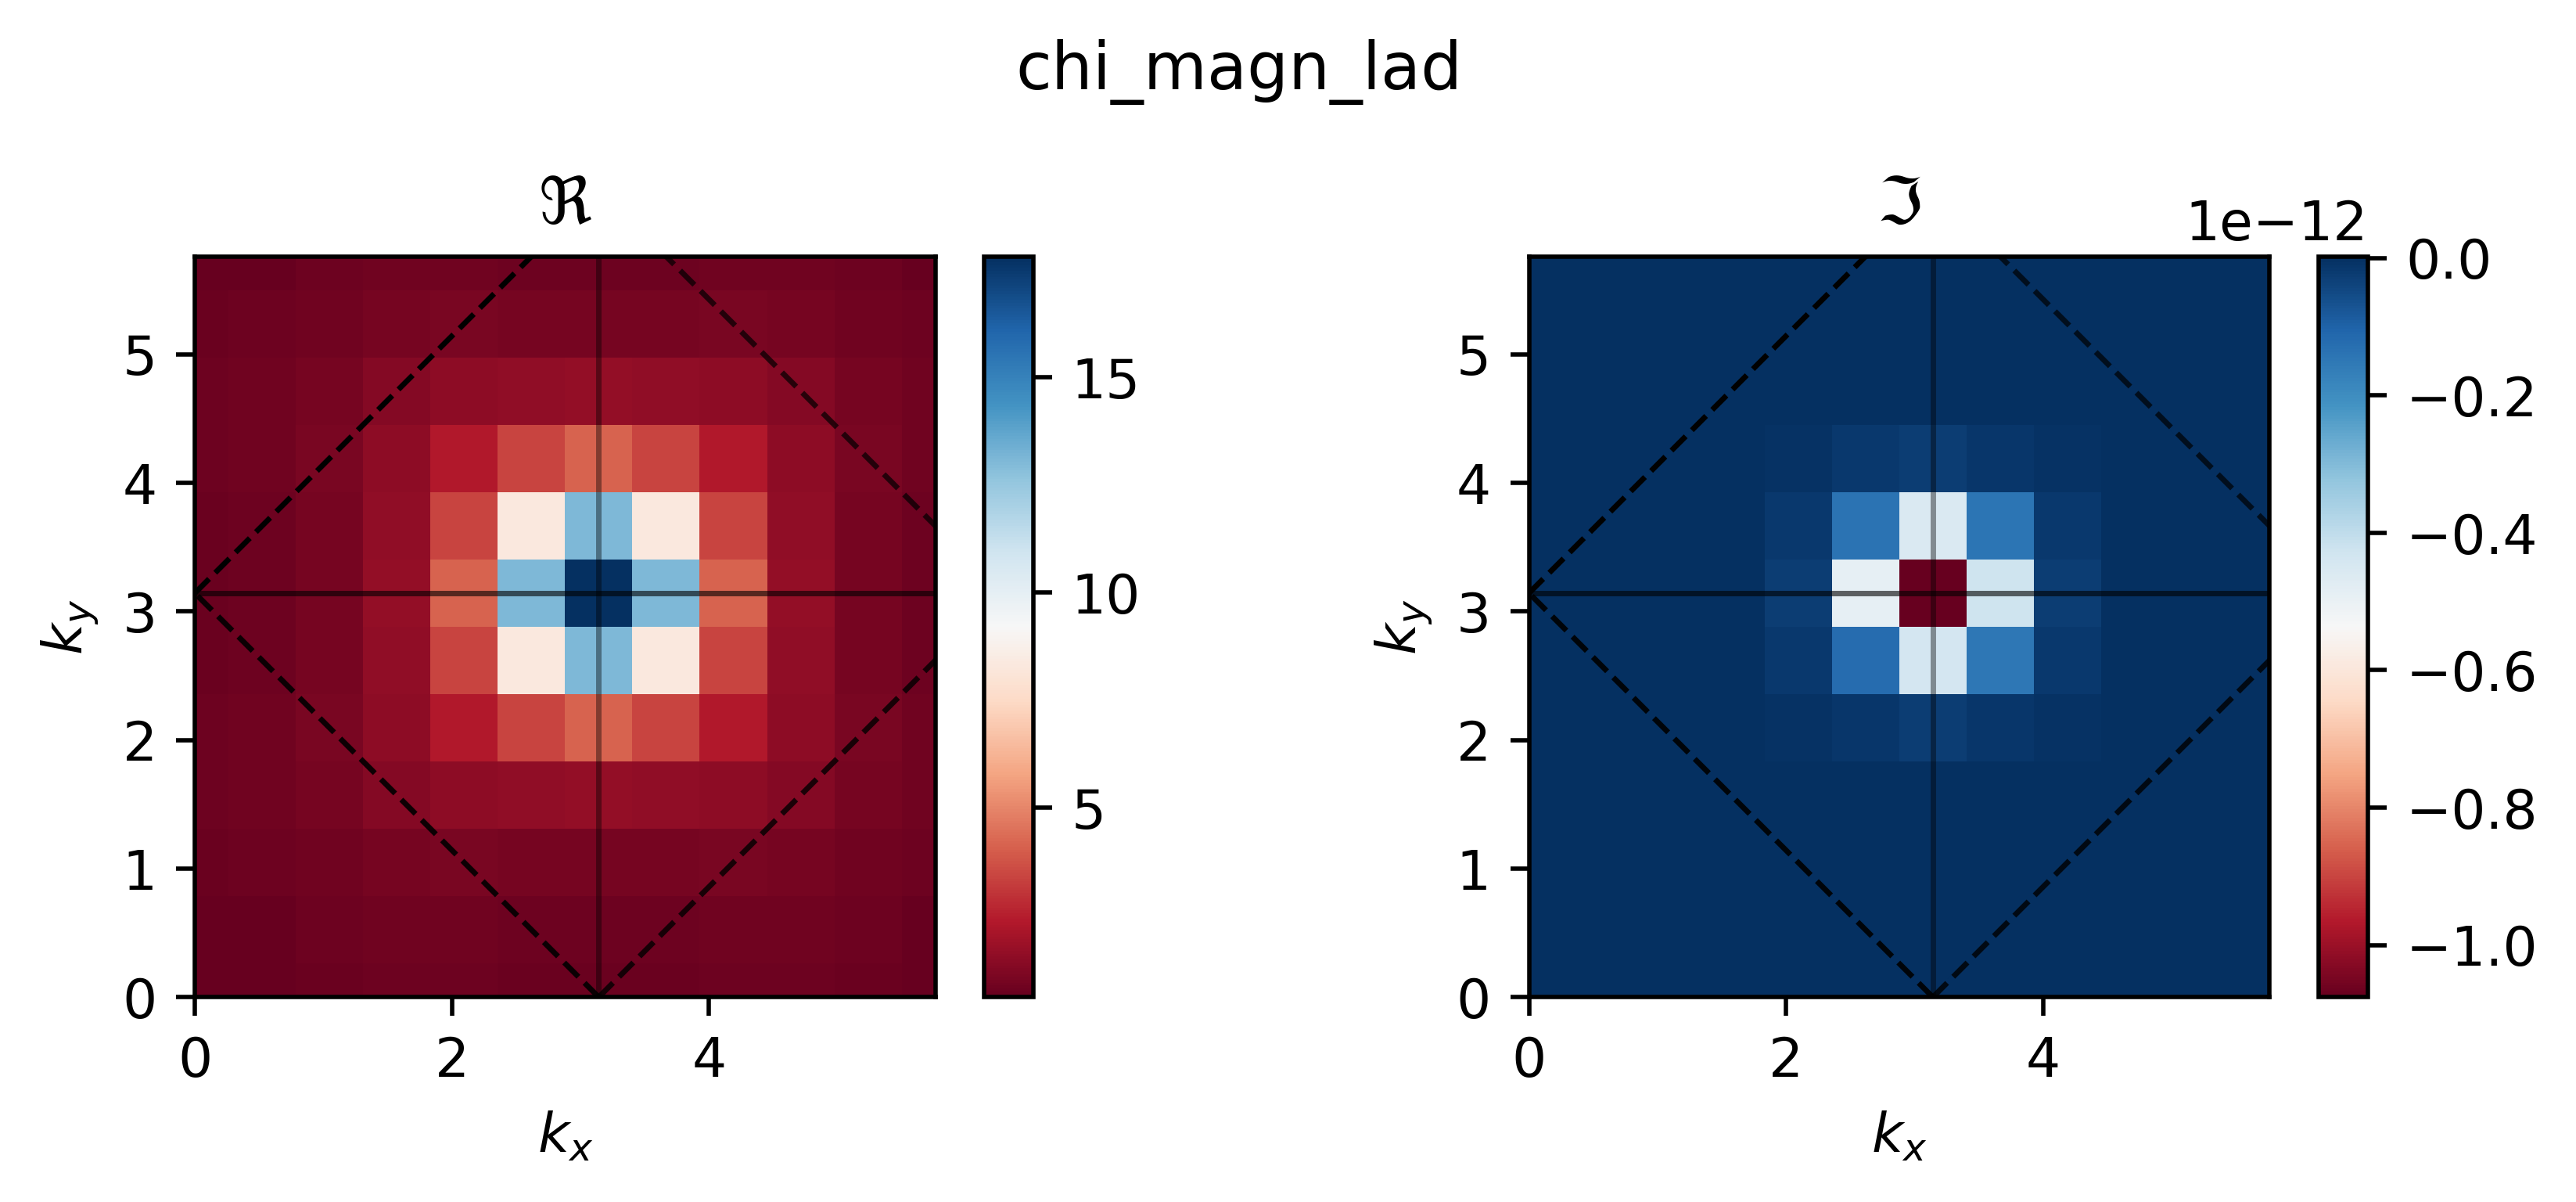

In [22]:
plotting.plot_kx_ky(chi_lam_magn[:,:,0,niw_core], k_grid.kx, k_grid.ky,name='chi_magn_lad',verbose=True,do_save=False)